## Gradient-Based Optimiztion for IK problem:   
***
A greate resource for IK based on gradient descent is here:   
https://www.youtube.com/watch?v=yx0-F9bMTOA 

The gradient descent leads the direction for the next iteration given and initial configuration state like `q_init`. We use the gradient to know which direction to go. It updates the q (joint values) based on the error in the task space. Also, there is learning rate called $\alpha$ which determines how big of a step we want to take twoard the min. For manipulators, the gradient is the Jacobian to project/ convert the error in task-space to joint space. In general we update the joint values with:          
      
$\Delta \theta = - \alpha (\frac{\partial F}{\partial \theta})^T$       

$F$ is the objective function.


In [1]:
import numpy as np
import time
from copy import deepcopy
from IPython.display import clear_output, SVG, display
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Box,
    Cylinder,
    DiagramBuilder,
    InverseKinematics,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    RigidTransform,
    Role,
    RollPitchYaw,
    RotationMatrix,
    Solve,
    StartMeshcat,
    JacobianWrtVariable,
    Parser,
    RevoluteJoint,
    JointSliders
)

from manipulation.meshcat_utils import (  # TODO(russt): switch to pydrake version
    _MeshcatPoseSliders,
)
from manipulation.scenarios import AddIiwa, AddShape, AddWsg
from manipulation.utils import ConfigureParser, running_as_notebook
from scipy.spatial.transform import Rotation as R


In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7005


### GBO 1, 2, 3. First Approach. 
Min distance in C-space. 
We can define the cost function as the quadratic of the error in joint space. Subject to satisfying 
Jacobian relationship. With $\Delta \theta = \theta_{target} - \theta$

$min \space {1\over2}\Delta\theta^T\Delta\theta$    
$s.t. ~~ \Delta x = J(\theta) \Delta \theta$

With Largrange multiplier we can solve the problem which is:      
$\Delta \theta = \alpha J^\# \Delta x$

We need the pseudo inverse of the jacobian to use in the iteration for updating the joint values. So the gradient descent basically looks like:      
$\theta_{k+1} = \theta_{k} + \alpha J^{\#} \Delta x$        

using the pseduo inverse $J^{\#}$ makes the optmization process to look for the shortest path in C-space. As a result, this method converges faster relative to the other one but matrix inversion is necessary here.

The Kuka arm here is redundant manipulator and psedue inverse of the Jacobian
would be a better approach to find the closest q values in the next step. There are infinte solution basically but psedudo inverse will give us the one that is the min in least square sense.      

Let's add more constraints:     
joint limits: $\theta > \theta_{lb}$     
This means $\theta_{target} - \theta < \theta_{target} - \theta_{lb}$. So we have:      
$s.t. ~~ \Delta \theta < \Delta \theta_{lb} $

In [3]:
def calcCost(q_current, q_next):
    return 1/2*np.linalg.norm(q_current - q_next)

def calcDeltaX(p_current, quat_current, p_target, quat_target) -> np.ndarray:
    '''
    Calculates error in Cartesian space

    Arguments:
        x: current pose.
        y: target pose

    Returns:
        difference in pose
    '''

    # position current to target
    position_error = p_target - p_current
    
    # Rc, Rtarget,. Rc * Rct = Rt => Rct = Rt * Rc^-1
    # quaternion current to target
    r_current_inv = R.from_quat(quat_current).inv()
    rct = R.from_quat(quat_target) * r_current_inv
    r_error = rct.as_rotvec() # angle * axis

    out = np.zeros(6)
    out[:3] = r_error
    out[3:] = position_error
    return out

lower_position:
 [[-2.967]
 [-2.094]
 [-2.967]
 [-2.094]
 [-2.967]
 [-2.094]
 [-3.054]]
upper_position:
 [[2.967]
 [2.094]
 [2.967]
 [2.094]
 [2.967]
 [2.094]
 [3.054]]
Keyboard Controls:
roll : KeyQ / KeyE
pitch : KeyW / KeyS
yaw : KeyA / KeyD
x : KeyJ / KeyL
y : KeyI / KeyK
z : KeyO / KeyU
Press the 'Stop PoseSliders' button in Meshcat to continue.


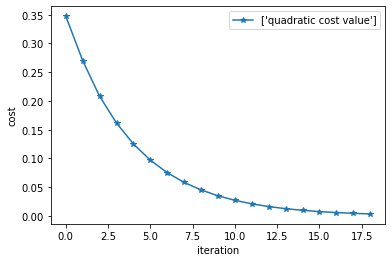

None

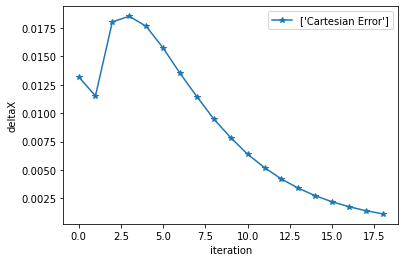

None

converged at iteration 19. Catesian error: 0.0009108049976184421 cost: 0.0035586913543395713
solution:
[[ 0.259  0.085 -0.291 -1.218  0.033  1.592 -0.031]]


In [4]:
def teleop_inverse_kinematics():
    # params
    alpha = 0.2 # learning rate
    max_iteration = 100 
    min_deltaX = 1e-3 # error threshold in Cartesian space between current pose of the end-effector and the target

    np.set_printoptions(precision=3, suppress=True)

    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    iiwa = AddIiwa(plant, "with_box_collision")
    wsg = AddWsg(plant, iiwa, welded=True)
    box = AddShape(plant, Box(0.1, 0.1, 0.1), "box")
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("box", box),
        RigidTransform([0.4, 0.0, 0.5]),
    )
    plant.Finalize()

    lower_position = plant.GetPositionLowerLimits().reshape(7,1)
    upper_position = plant.GetPositionUpperLimits().reshape(7,1)
    print('lower_position:\n', lower_position)
    print('upper_position:\n', upper_position)

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        scene_graph,
        meshcat,
        MeshcatVisualizerParams(delete_prefix_initialization_event=False),
    )
    
    collision = MeshcatVisualizer.AddToBuilder(
        builder,
        scene_graph,
        meshcat,
        MeshcatVisualizerParams(
            prefix="collision", role=Role.kProximity, visible_by_default=False
        ),
    )

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)

    q0 = plant.GetPositions(plant_context)
    gripper_frame = plant.GetFrameByName("body", wsg)
    base_frame = plant.GetBodyByName("iiwa_link_0").body_frame()

    q_pref = np.array([0.244,  0.414, -0.288, -1.254,  0.084,  0.819, -0.047]).reshape(7,1)
                    
    def my_callback(context, pose):
    
        # target pose
        p_target = pose.translation()
        quat_target = R.from_matrix(pose.rotation().matrix()).as_quat()

        # initial state
        q_current = q0
        it = 0

        costs = []
        errors = [] # Cartesian error
        while it < max_iteration:
            # forward kineamtics. get gripper frame
            transform = gripper_frame.CalcPoseInWorld(plant_context)
            quat_current = R.from_matrix(transform.rotation().matrix()).as_quat()
            p_current = transform.translation()

            # check error between current pose of the end-effector and the target pose
            deltaX = calcDeltaX(p_current, quat_current, p_target, quat_target)
            error = np.linalg.norm(deltaX)
            if error < min_deltaX:
                break

            # calc jacobain
            J = plant.CalcJacobianSpatialVelocity(
                context=plant_context, 
                with_respect_to=JacobianWrtVariable.kQDot,
                frame_B=gripper_frame, 
                p_BoBp_B=np.zeros(3),
                frame_A=plant.world_frame(),
                frame_E=plant.world_frame()
            )
            
            # calculate the next joint values by gradient descent equation
            q_current = q_current.reshape(7,1)
            q_next = q_current + alpha * np.linalg.pinv(J) @ deltaX.reshape(6,1) + \
                      1.8 *  (np.identity(7) - np.linalg.pinv(J) @ J) @ (q_pref - q_current)
            # use null space to enforce prefered joint configuration:
            # print('null:\n', (np.identity(7) - np.linalg.pinv(J) @ J) @ (q_pref - q_current))

            # enforce joint limits (constraints)
            q_next = np.minimum(upper_position, q_next)
            q_next = np.maximum(lower_position, q_next)

            # update the robot in the scene
            plant.SetPositions(plant_context, q_next)

            cost = calcCost(q_current, q_next)
            costs.append(cost)

            errors.append(error)

            q_current = q_next
            it += 1

        plt.figure()
        plt.plot(range(it), costs, marker='*', label=["quadratic cost value"])
        plt.xlabel("iteration")
        plt.ylabel("cost")
        plt.legend()
        display(plt.show())

        plt.figure()
        plt.plot(range(it), errors, marker='*', label=["Cartesian Error"])
        plt.xlabel("iteration")
        plt.ylabel("deltaX")
        plt.legend()
        display(plt.show())

        if it == max_iteration:
            print('did not converge in {} iterations. Cost is at: {}'.format(max_iteration, cost))
        else:
            print('converged at iteration {}. Catesian error: {} cost: {}'.format(it, error, cost))
            print('solution:\n{}'.format(q_current.T))
        clear_output(wait=True)

    meshcat.DeleteAddedControls()
    sliders = _MeshcatPoseSliders(meshcat)
    sliders.SetPose(
        plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("body", wsg))
    )
    sliders.Run(visualizer, context, my_callback)


teleop_inverse_kinematics()

### GBO 1, 2, 3. Second Approach. 
Min distance in Cartesian space for objective function.     

Forward kinematics:         
$x = F(\theta)$             
$\Delta x = x_{target} - F(\theta)$             


Optimization problem:               
$min \space {1\over2}\Delta x^T\Delta x$    

No inverse matrix needed, its a simpler computatoin but needs many iterations to converge. The reason is that it does not aim at find the shortest path in C-space neccesarily. Cost function does not inforce that.        

The gradient descent basically looks like:              
$\theta_{k+1} = \theta_{k} + \alpha J^T \Delta x$        

To check if the gradient of a functino is correct, we can use finite difference approximation:      
<img src="./share/finit_diff_jac.png" width=600>        
$h$ is the increment; the smaller, the more accurate approximation.

In [3]:
def calcCost(deltaX):
    return 1/2*np.linalg.norm(deltaX)


def calcDeltaX(p_current, quat_current, p_target, quat_target) -> np.ndarray:
    '''
    Calculates error in Cartesian space

    Arguments:
        x: current pose.
        y: target pose

    Returns:
        difference in pose
    '''

    # position current to target
    position_error = p_target - p_current
    
    # Rc, Rtarget,. Rc * Rct = Rt => Rct = Rt * Rc^-1
    # quaternion current to target
    r_current_inv = R.from_quat(quat_current).inv()
    rct = R.from_quat(quat_target) * r_current_inv
    r_error = rct.as_rotvec() # angle * axis

    out = np.zeros(6)
    out[:3] = r_error
    out[3:] = position_error
    return out

def checkJac(J, plant, plant_context, body):
    '''use finite difference approximation to check if given Jacobian is correct'''

    def getFK(plant_context, q_current, q_next):
        plant.SetPositions(plant_context, q_next)
        frame = plant.GetFrameByName("body", body)
        transform = frame.CalcPoseInWorld(plant_context)
        quat1 = R.from_matrix(transform.rotation().matrix())
        p1 = transform.translation()

        # revert back the plant to what it was
        plant.SetPositions(plant_context, q_current)
        return p1, quat1
    
    q_current = plant.GetPositions(plant_context)
    frame = plant.GetFrameByName("body", body)
    transform = frame.CalcPoseInWorld(plant_context)
    quat_current = R.from_matrix(transform.rotation().matrix())
    p_current = transform.translation()

    h = 0.01
    num_joints = J.shape[1]
    J_apprx = np.zeros(J.shape)
    for ix in range(num_joints):
        q_next = deepcopy(q_current)
        q_next[ix] = q_next[ix] + h

        p_next, quat_next = getFK(plant_context, q_current, q_next)

        qcn = quat_next * quat_current.inv()
        quat_delta = qcn.as_rotvec()

        p_delta = p_next - p_current

        # fill column of the Jacobian:
        J_apprx[:3,ix] = quat_delta
        J_apprx[3:,ix] = p_delta
    
    J_apprx = J_apprx/h
    np.set_printoptions(precision=1)
    print(np.sum(J-J_apprx))

In [4]:
def teleop_inverse_kinematics():
    # params
    alpha = 0.2
    max_iteration = 800
    min_deltaX = 1e-3

    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa, welded=True)
    plant.Finalize()

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        scene_graph,
        meshcat,
        MeshcatVisualizerParams(delete_prefix_initialization_event=False),
    )

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)

    q0 = plant.GetPositions(plant_context)
    gripper_frame = plant.GetFrameByName("body", wsg)
    base_frame = plant.GetBodyByName("iiwa_link_0").body_frame()
    # Frame.CalcPoseInWorld().translation()

    def my_callback(context, pose):
    
        # target pose
        p_target = pose.translation()
        quat_target = R.from_matrix(pose.rotation().matrix()).as_quat()

        # initial state
        q_current = q0
        it = 0

        costs = [] # Cartesian Error
        while it < max_iteration:
            # forward kineamtics. get gripper frame
            transform = gripper_frame.CalcPoseInWorld(plant_context)
            quat_current = R.from_matrix(transform.rotation().matrix()).as_quat()
            p_current = transform.translation()

            # check error between current pose of the end-effector and the target pose
            deltaX = calcDeltaX(p_current, quat_current, p_target, quat_target)
            cost = calcCost(deltaX)

            if cost < min_deltaX:
                break

            # calc jacobain
            J = plant.CalcJacobianSpatialVelocity(
                context=plant_context, 
                with_respect_to=JacobianWrtVariable.kQDot,
                frame_B=gripper_frame, 
                p_BoBp_B=np.zeros(3),
                frame_A=plant.world_frame(),
                frame_E=plant.world_frame()
            )
            
            checkJac(J, plant, plant_context, wsg)
            return
            # calculate the next joint values by gradient descent equation
            q_current = q_current.reshape(7,1)
            q_next = q_current + alpha * J.T @ deltaX.reshape(6,1)

            # update the robot in the scene
            plant.SetPositions(plant_context, q_next)

            costs.append(cost)

            q_current = q_next
            it += 1

        plt.figure()
        plt.plot(range(it), costs, label=["quadratic cost value"])
        plt.xlabel("iteration")
        plt.ylabel("cost")
        plt.legend()
        display(plt.show())

        if it == max_iteration:
            print('did not converge in {} iterations. Cost is at: {}'.format(max_iteration, cost))
        else:
            print('converged at iteration {}. Cost: {}'.format(it, cost))
            print('solution:\n{}'.format(q_current.T))
        clear_output(wait=True)

    meshcat.DeleteAddedControls()
    sliders = _MeshcatPoseSliders(meshcat)
    sliders.SetPose(
        plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("body", wsg))
    )
    sliders.Run(visualizer, context, my_callback)


teleop_inverse_kinematics()

Keyboard Controls:
roll : KeyQ / KeyE
pitch : KeyW / KeyS
yaw : KeyA / KeyD
x : KeyJ / KeyL
y : KeyI / KeyK
z : KeyO / KeyU
Press the 'Stop PoseSliders' button in Meshcat to continue.
0.008911041276842517


### GBO 5: Dual manipulators
Min distance in Cartesian space between the two end-effector for objective function. We do not have to have the orientatio no of the end-effector of the two robots match. We may want the direciont of the gripper to be parallel for example instead of having the whole orientation matching. There is a fixed  transform between the two end-effector in the error function.

[For the math, look at dual.png](./dual_manip.pdf)


In [3]:
def calcCost(deltaX):
    return 1/2*np.linalg.norm(deltaX)

def calcDeltaX(p_current, quat_current, p_target, quat_target) -> np.ndarray:
    '''
    Calculates error in Cartesian space

    Arguments:
        x: current pose.
        y: target pose

    Returns:
        difference in pose
    '''

    # position current to target
    position_error = p_target - p_current
    
    # creat transformation to make the angles facing each other. Rotate around z then, you have y-axis 
    # facing which means the grippers are facing
    angle = np.pi
    axis = np.array([0,0,1])
    quat = np.zeros(4)
    quat[:3] = axis * np.sin(angle/2) # qx,qy,qz,qw
    quat[3] = np.cos(angle/2)
    rot = R.from_quat(quat)
    quat_target = R.from_quat(quat_target)
    quat_target = (quat_target * rot).as_quat()

    # Rc, Rtarget,. Rc * Rct = Rt => Rct = Rt * Rc^-1
    # quaternion current to target
    r_current_inv = R.from_quat(quat_current).inv()
    rct = R.from_quat(quat_target) * r_current_inv
    r_error = rct.as_rotvec() # angle * axis

    out = np.zeros(6)
    out[:3] = r_error # now this rotaion error here contains the fixed transformation to have the grippers facing each other
    out[3:] = position_error
    return out

def AddIiwaAt(plant, q0, base_location=[0,0,0], model_instance_name="iiwa_7"):
    parser = Parser(plant)
    iiwa = parser.AddModelsFromUrl(
        f"package://drake_models/iiwa_description/sdf/iiwa7_no_collision.sdf"
    )[0]
    plant.RenameModelInstance(iiwa, model_instance_name)

    plant.WeldFrames(plant.world_frame(), 
                    plant.GetFrameByName("iiwa_link_0", iiwa), 
                    RigidTransform(base_location)
                )

    # Set default positions:
    index = 0
    for joint_index in plant.GetJointIndices(iiwa):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1

    return iiwa

def AddWsgWithName(plant, iiwa_model_instance, 
                roll=np.pi / 2.0, welded=False, sphere=False, name='gripper'):
    parser = Parser(plant)
    ConfigureParser(parser)
    if welded:
        if sphere:
            file = "package://manipulation/schunk_wsg_50_welded_fingers_sphere.sdf"
        else:
            file = "package://manipulation/schunk_wsg_50_welded_fingers.sdf"
    else:
        file = (
            "package://drake_models/wsg_50_description/sdf/schunk_wsg_50_with_tip.sdf"
        )

    directives = f"""
directives:
- add_model:
    name: gripper
    file: {file}
"""
    gripper = parser.AddModelsFromString(directives, ".dmd.yaml")[0]
    plant.RenameModelInstance(gripper, name)


    X_7G = RigidTransform(RollPitchYaw(np.pi / 2.0, 0, roll), [0, 0, 0.09])
    plant.WeldFrames(
        plant.GetFrameByName("iiwa_link_7", iiwa_model_instance),
        plant.GetFrameByName("body", gripper),
        X_7G,
    )
    return gripper

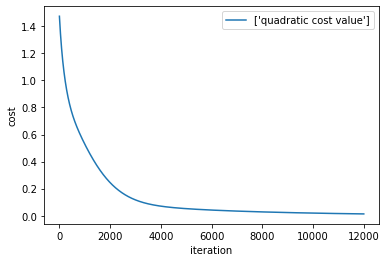

None

did not converge in 12000 iterations. Cost is at: 0.013131934177912747


In [4]:
def teleop_inverse_kinematics():
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    # params
    alpha = 0.001
    max_iteration = 12000
    min_deltaX = 1e-3

    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)

    q0_1 = [0.8, 0.1, 0, -0.8, 0, 1.0, 0]    
    iiwa_1 = AddIiwaAt(plant, q0_1, [0.0, 0.5, 0.0], "kuka1")
    wsg_1 = AddWsgWithName(plant, iiwa_1, welded=True, name="gripper1")

    q0_2 = [0.1, 0.4, 0, -1.2, 0, 1.0, 0]    
    iiwa_2 = AddIiwaAt(plant, q0_2, [0.0, -0.5, 0.0], "kuka2")
    wsg_2 = AddWsgWithName(plant, iiwa_2, welded=True, name="gripper2")

    plant.Finalize()

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        scene_graph,
        meshcat,
        MeshcatVisualizerParams(delete_prefix_initialization_event=False),
    )
    # sliders = builder.AddSystem(JointSliders(meshcat, plant))

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    
    q0_1 = plant.GetPositions(plant_context, iiwa_1)
    gripper_frame_1 = plant.GetFrameByName("body", wsg_1)
    base_frame_1 = plant.GetBodyByName("iiwa_link_0", iiwa_1).body_frame()

    q0_2 = plant.GetPositions(plant_context, iiwa_2)
    gripper_frame_2 = plant.GetFrameByName("body", wsg_2)
    base_frame_2 = plant.GetBodyByName("iiwa_link_0", iiwa_2).body_frame()

    # to show the robots at their inital configurations    
    diagram.ForcedPublish(context)
    time.sleep(3)

    # initial state
    q_current = np.zeros(14)
    q_current[:7] = q0_1
    q_current[7:] = q0_2
    q_current.reshape(14,1)

    it = 0

    costs = [] # Cartesian Error
    while it < max_iteration:
        # forward kineamtics. get gripper frame
        transform_1 = gripper_frame_1.CalcPoseInWorld(plant_context)
        quat_current_1 = R.from_matrix(transform_1.rotation().matrix()).as_quat()
        p_current_1 = transform_1.translation()

        transform_2 = gripper_frame_2.CalcPoseInWorld(plant_context)
        quat_current_2 = R.from_matrix(transform_2.rotation().matrix()).as_quat()
        p_current_2 = transform_2.translation()

        # check error between current pose of the end-effector and the target pose
        deltaX = calcDeltaX(p_current_1, quat_current_1, p_current_2, quat_current_2)
        # deltaX = deltaX[3:] # we must care only about the position
        cost = calcCost(deltaX)

        if cost < min_deltaX:
            break

        # calc jacobain
        J1 = plant.CalcJacobianSpatialVelocity(
            context=plant_context, 
            with_respect_to=JacobianWrtVariable.kQDot,
            frame_B=gripper_frame_1, 
            p_BoBp_B=np.zeros(3),
            frame_A=plant.world_frame(),
            frame_E=plant.world_frame()
        )
        # print(J1.shape)
        np.set_printoptions(precision=3, suppress=True)
        # print(J1)
        J2 = plant.CalcJacobianSpatialVelocity(
            context=plant_context, 
            with_respect_to=JacobianWrtVariable.kQDot,
            frame_B=gripper_frame_2, 
            p_BoBp_B=np.zeros(3),
            frame_A=plant.world_frame(),
            frame_E=plant.world_frame()
        )
        # print(J2)
            
        # calculate the next joint values by gradient descent equation
        J = J1 - J2
        # J = J[3:,:]
        q_next = q_current.reshape(14,1) + alpha * J.T  @ deltaX.reshape(6,1) # J.T, np.linalg.pinv(J)

        # update the robot in the scene
        plant.SetPositions(plant_context, q_next)
        diagram.ForcedPublish(context)

        costs.append(cost)

        q_current = q_next
        it += 1
        
    
    plt.figure()
    plt.plot(range(it), costs, label=["quadratic cost value"])
    plt.xlabel("iteration")
    plt.ylabel("cost")
    plt.legend()
    display(plt.show())

    if it == max_iteration:
        print('did not converge in {} iterations. Cost is at: {}'.format(max_iteration, cost))
    else:
        print('converged at iteration {}. Cost: {}'.format(it, cost))
        print('solution:\n{}'.format(q_current.T))
    clear_output(wait=True)

    diagram.ForcedPublish(context)

teleop_inverse_kinematics()